<a href="https://colab.research.google.com/github/lerrlera/IAT360-CV-Project-Group14/blob/myBranch/CV_Sign_For_Help.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Computer Vision Problem: Sign For Help
###Group 14
Our computer vision project aims to develop a model capable of detecting and recognizing the [Signal for Help (SFH)](https://canadianwomen.org/signal-for-help/) hand gesture–a universal distress signal used by individuals experiencing violence or abuse. The problem we are addressing is the lack of accessible and automated tools that can identify this silent call for help, which could support early intervention and improve personal safety.

This is an important issue because many victims cannot ask for help out loud (e.g., the abuser is nearby), and this automatic gesture recognition could enable faster responses and potentially save lives. Our model could be used in real life to detect SFH through smartphone cameras, wearable devices, telehealth sessions, or public service kiosks, enabling faster intervention and support for individuals experiencing abuse.


## Importing Google Drive & Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy what's in google drive to local drive folder

In [ ]:
import shutil
import os

# Define source and destination paths
source_path = "/content/drive/MyDrive/IAT360 - SFH Project"
destination_path = "/content/IAT360"

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Copy the dataset to a writable location
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

# Update dataset_path to the new location
dataset_path = destination_path

print(f"Dataset copied to: {dataset_path}")

Dataset copied to: /content/IAT360


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

KeyboardInterrupt: 

## Dataset Description
For this project, we need image data resembling two specific hand gestures as a picture below:

*   An open hand with tucked thumb
*   A closed hand with a trapped thumb



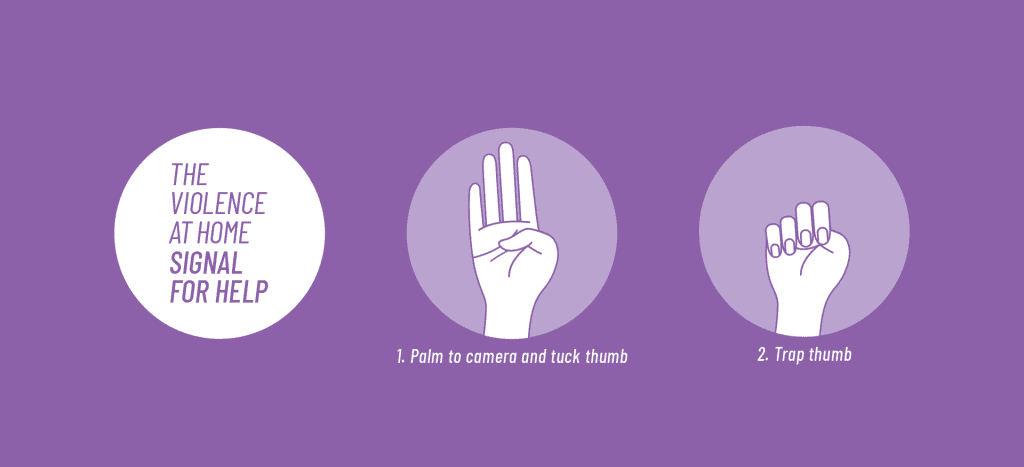

**Source:** Signal for help | Use Signal to ask for help.  (n.d.). Canadian Women’s Foundation. https://canadianwomen.org/signal-for-help/

###Details

These images were sourced from 2 existing datasets and organized into 2 class folders, ‘open_hand’ and ‘closed_hand’ for a classification task. Specifically, we used images labelled ‘B’ from the ASL dataset from the ASL dataset for our ‘open_hand’ class, and images labelled ‘A’ and ‘S’ for our ‘closed_hand’ class. We also supplemented our data with additional images from the Hands Images dataset, which better capture the specific thumb positions we needed and include hands wearing gloves.

We have 2 labels, ‘open_hand’ and ‘closed_hand’. Since this is a supervised classification task, the folder structure itself serves as a label; images in the ‘open_hand’ folder belong to ‘open_hand’ class, and the same labelling rule applies for those in the ‘closed_hand’ folder.

###Adding More Data
We also added 30 (15 for each class) new images each sourced from stock images (Adobe), our own photos of hands...


###Data Split

Total number of images in each class was: 3,052. 2/3 of this data should was used as training data, the rest is for evaluation:

**‘open_hand’**
*   2,035 images in train folder
*   1,017 images in test folder

**‘closed_hand’**
*   2,035 images in train folder
*   1,017 images in test folder


Here is a Google Drive link to the zipped datasets used in this project:



*   [SFH Dataset](https://drive.google.com/drive/folders/1puxrFn5ijZAyBCCPxtzP0QTTBX_QTSmd?usp=sharing)


Here are existing datasets we used to collect this data:

*   [ASL Alphabet Dataset on Kaggle](https://www.kaggle.com/datasets/grassknoted/asl-alphabet)
*   [Hands Images Dataset on Hugging Face](https://huggingface.co/datasets/trashsock/hands-images)

## Data Preprocessing

For preprocessing:
- We have to convert the dataset into that acceptable by YOLO.
  - Heirarchy of folders should be the one accepted by YOLO
  - Labels format should be darknet YOLO.
  - Labels files should be .txt files


### Heirarchy of Folders Correction

Defining paths to train and test folders.

Original codes below: https://github.com/jaejams/Week3-ClassicML/blob/main/week_3_machinelearning.ipynb

In [ ]:
#importing the required libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')

## Extracting the file directories
So that the images could be split into train & validation sets.

In [ ]:
import os
import glob
import numpy as np # Import numpy to use np.array()

def load_data():
    X, y = [], []
    count = 0
    # The glob pattern seems to be correct for your intended file structure
    for file in glob.glob("/content/IAT360/sfh-dataset/*/*.jpg"):
        # This line correctly extracts ONLY the file name (e.g., 'image.jpg')
        file_name = os.path.basename(file)
        # Separate the name and extension (base_name will be 'open_hand_0153')
        base_name = os.path.splitext(file_name)[0]

        # split the string from the RIGHT only once at the underscore.
        # 'open_hand_0153'.rsplit('_', 1) -> ['open_hand', '0153']
        # Taking the [0] element gives us 'open_hand'
        label = base_name.rsplit('_', 1)[0]

        # Append the file name (full path) to the list X
        X.append(file)
        # If wanting the partial path
        # X.append(file_name)
        y.append(label)

        count += 1
        # The print statement is kept, assuming you want to see the progress
        print('\r' + f' Processed {count}/{1440} image samples', end=' ')

    # Return the list of file names as a numpy array
    return np.array(X), np.array(y)

In [ ]:
hands, labels = load_data()
print(hands)
print(labels)

 Processed 2144/1440 image samples ['/content/IAT360/sfh-dataset/open_hand/open_hand_0651.jpg'
 '/content/IAT360/sfh-dataset/open_hand/open_hand_0153.jpg'
 '/content/IAT360/sfh-dataset/open_hand/open_hand_0458.jpg' ...
 '/content/IAT360/sfh-dataset/closed_hand/closed_hand_0155.jpg'
 '/content/IAT360/sfh-dataset/closed_hand/closed_hand_0103.jpg'
 '/content/IAT360/sfh-dataset/closed_hand/closed_hand_0195.jpg']
['open_hand' 'open_hand' 'open_hand' ... 'closed_hand' 'closed_hand'
 'closed_hand']


In [ ]:
from sklearn.model_selection import train_test_split
#these are the same codes, but we are just using different data.
#putting these into 80, 20 split (train: 80, validation: 20)


############# Unscaled test/train set #############
X_train, X_test, y_train, y_test = train_test_split(
    hands, #feature set
    labels, #label set
    test_size=0.2,
    random_state=42 #random_state - everytime you run this code, it will give you the same split. If you change it, it will give you a different split. actually shuffle data based on random number.
)

Then, put these images into separate folders.

In [ ]:
import os
import shutil


# Base directories
base_dir = "/content/IAT360/Final_Datasets/Final_data/images_for_yolo"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

os.makedirs(base_dir, exist_ok=True)

# Create base train/val folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Function to get class name from filename
def get_class_from_filename(filename):
    base_name = os.path.basename(filename)
    return base_name.rsplit('_', 1)[0]  # get part before the first underscore

# Move training images into class folders
for img_path in X_train:
    class_name = get_class_from_filename(img_path)
    class_folder = os.path.join(train_dir, class_name)
    os.makedirs(class_folder, exist_ok=True)
    shutil.move(img_path, class_folder)

# Move validation images into class folders
for img_path in X_test:
    class_name = get_class_from_filename(img_path)
    class_folder = os.path.join(val_dir, class_name)
    os.makedirs(class_folder, exist_ok=True)
    shutil.move(img_path, class_folder)

print("✅ Done! Images moved into train/val class folders.")


✅ Done! Images moved into train/val class folders.


# Custom gesture classification using YOLO

YOLOv8 classification models use the -cls suffix, i.e. yolov8n-cls.pt and are pretrained on ImageNet. See Classification Docs for full details.

Original file: https://github.com/jaejams/Computer-Vision-Project-Overview/blob/main/copy_of_yolov8_tutorial.ipynb
https://github.com/jaejams/Computer-Vision-Project/blob/main/ComputerVisionProject-revised.ipynb

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.218 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 40.1/107.7 GB disk)


In [ ]:
# Load YOLOv8n-cls, train it on mnist160 for 3 epochs and predict an image with it
from ultralytics import YOLO

model = YOLO('yolov8n-cls.pt')  # load a pretrained YOLOv8n classification model


In [ ]:
model

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
model.train(data="/content/IAT360/Final_Datasets/Final_data/images_for_yolo",epochs=1,patience=5,batch=8, lr0=0.0005,imgsz=640)

Ultralytics 8.3.218 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/IAT360/Final_Datasets/Final_data/images_for_yolo, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, pe

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78f0b428dc40>
curves: []
curves_results: []
fitness: 0.9941724836826324
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9883449673652649, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9941724836826324}
save_dir: PosixPath('/content/runs/classify/train')
speed: {'preprocess': 0.0025055990671333426, 'inference': 109.949455121214, 'loss': 0.0001048414918786324, 'postprocess': 0.0002727179478629794}
task: 'classify'
top1: 0.9883449673652649
top5: 1.0

In [ ]:
model= YOLO("/content/runs/classify/train/weights/best.pt")
metrics = model.val()  # no arguments needed, dataset and settings remembered
print(metrics)


Ultralytics 8.3.218 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/IAT360/Final_Datasets/Final_data/images_for_yolo/train... found 1715 images in 2 classes ✅ 
val: /content/IAT360/Final_Datasets/Final_data/images_for_yolo/val... found 429 images in 2 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 371.7±126.5 MB/s, size: 13.7 KB)
val: Scanning /content/IAT360/Final_Datasets/Final_data/images_for_yolo/val... 429 images, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 506.0Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 27/27 0.5it/s 56.0s
                   all      0.988          1
Speed: 0.0ms preprocess, 106.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.Confusi

In [ ]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/classify/train/confusion_matrix_normalized.png')

# Test the results

In [ ]:
from ultralytics import YOLO

# Load your trained model
model = YOLO("/content/runs/classify/train/weights/best.pt")

# Run prediction on a folder of images
results = model.predict("/content/IAT360/valeriya_new_data/**/*.*", save=True)



image 1/30 /content/IAT360/valeriya_new_data/closed_hand-valeriya/closed_hand_3023.jpeg: 640x640 closed_hand 1.00, open_hand 0.00, 107.8ms
image 2/30 /content/IAT360/valeriya_new_data/closed_hand-valeriya/closed_hand_3024.jpeg: 640x640 closed_hand 0.99, open_hand 0.01, 100.0ms
image 3/30 /content/IAT360/valeriya_new_data/closed_hand-valeriya/closed_hand_3025.jpeg: 640x640 closed_hand 0.97, open_hand 0.03, 93.7ms
image 4/30 /content/IAT360/valeriya_new_data/closed_hand-valeriya/closed_hand_3026.jpeg: 640x640 closed_hand 1.00, open_hand 0.00, 98.1ms
image 5/30 /content/IAT360/valeriya_new_data/closed_hand-valeriya/closed_hand_3027.jpeg: 640x640 closed_hand 1.00, open_hand 0.00, 95.8ms
image 6/30 /content/IAT360/valeriya_new_data/closed_hand-valeriya/closed_hand_3028.jpeg: 640x640 closed_hand 1.00, open_hand 0.00, 97.9ms
image 7/30 /content/IAT360/valeriya_new_data/closed_hand-valeriya/closed_hand_3029.jpg: 640x640 closed_hand 0.99, open_hand 0.01, 99.4ms
image 8/30 /content/IAT360/valer

# Download

In [16]:
!zip -r runs.zip /content/runs
from google.colab import files
files.download("runs.zip")


  adding: content/runs/ (stored 0%)
  adding: content/runs/classify/ (stored 0%)
  adding: content/runs/classify/val2/ (stored 0%)
  adding: content/runs/classify/val2/val_batch2_labels.jpg (deflated 9%)
  adding: content/runs/classify/val2/val_batch1_labels.jpg (deflated 9%)
  adding: content/runs/classify/val2/val_batch2_pred.jpg (deflated 9%)
  adding: content/runs/classify/val2/val_batch1_pred.jpg (deflated 9%)
  adding: content/runs/classify/val2/confusion_matrix.png (deflated 33%)
  adding: content/runs/classify/val2/confusion_matrix_normalized.png (deflated 33%)
  adding: content/runs/classify/val2/val_batch0_pred.jpg (deflated 9%)
  adding: content/runs/classify/val2/val_batch0_labels.jpg (deflated 9%)
  adding: content/runs/classify/val/ (stored 0%)
  adding: content/runs/classify/val/val_batch2_labels.jpg (deflated 9%)
  adding: content/runs/classify/val/val_batch1_labels.jpg (deflated 9%)
  adding: content/runs/classify/val/val_batch2_pred.jpg (deflated 9%)
  adding: content

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
results=model('https://miro.medium.com/v2/resize:fit:510/format:webp/1*jW-Q9DvmB-zvM4hgJlBx3g.png', save=True)
#results
for r in results:
    print(r.probs)  # print the Probs object containing the detected class probabilities